# Task 1: Import Libraries

In [18]:
from PIL import Image
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns
from huggingface import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from torchvision import transforms
import sklearn
import numpy as np 
import torch
from datetime import datetime

# Task 2: Load the Dataset

In [19]:
# download the dataset
load_dataset('mnist',cache_dir='mnist_dataset')

path = 'mnist_dataset/'
train_validation_ds = load_dataset(path=path,split='train[:1000]')
test_ds = load_dataset(path=path,split='test[:100]')

splits = train_validation_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
validation_ds = splits['test']

/Users/saip/Library/Python/3.9/lib/python/site-packages/datasets/load.py:1491: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


# Task 3: Visualize the Dataset

In [20]:
train_ds['image'][449]

Text(0, 0.5, 'Frequency')

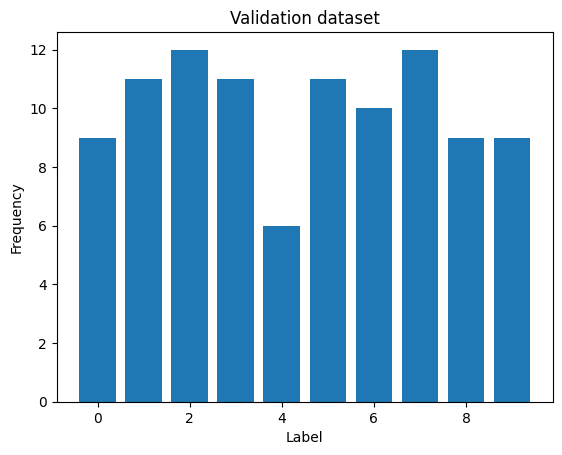

In [21]:
train_labels = Counter(train_ds['label'])
plt.clf()
plt.bar(train_labels.keys(),train_labels.values())
plt.title('Training dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')

val_labels = Counter(validation_ds['label'])
plt.clf()
plt.bar(val_labels.keys(),val_labels.values())
plt.title('Validation dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Task 4: Create a Mapping of Class Names to Index

In [22]:
id2label = {id : label for id,label in enumerate(train_ds.features['label'].names)}
label2id = {t[1] : t[0] for t in id2label.items()}
num_labels = len(id2label)

# Task 5: Load the Preprocessor for the Dataset

In [23]:
PRETRAINED_MODEL_NAME = 'google/vit-base-patch16-224'
processor = ViTImageProcessor.from_pretrained(PRETRAINED_MODEL_NAME)

# Task 6: Define Data Augmentations

In [24]:
image_mean, image_std = processor.image_mean, processor.image_std
height, width = processor.size['height'], processor.size['width']

normalize = transforms.Normalize(mean=image_mean,std=image_std)

_train_transforms = transforms.Compose([
                                    # transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
                                    transforms.Resize((height,width)),
                                    transforms.ToTensor(),
                                    normalize])

_validation_transforms = transforms.Compose([
                                    transforms.Resize((height,width)),
                                    transforms.ToTensor(),
                                    normalize])

# Task 7:  Implement Data Transformation

In [25]:
def train_transforms(batch):
    rgb_images = [img.convert('RGB') for img in batch['image']]
    batch['pixel_values'] = [_train_transforms(img) for img in rgb_images]
    return batch

def validation_transforms(batch):
    rgb_images = [img.convert('RGB') for img in batch['image']]
    batch['pixel_values'] = [_validation_transforms(img) for img in rgb_images]
    return batch

train_ds.set_transform(train_transforms)
validation_ds.set_transform(validation_transforms)
test_ds.set_transform(validation_transforms)

# Task 8: Collate the Function for DataLoader

In [26]:
def collate_fn(batch):
    pixel_values = torch.stack([sample['pixel_values'] for sample in batch])
    labels = torch.tensor([sample['label'] for sample in batch])
    return {'pixel_values' : pixel_values, 'labels' : labels}

# Task 9: Create a Model

In [27]:
model = ViTForImageClassification.from_pretrained(pretrained_model_name_or_path=PRETRAINED_MODEL_NAME, 
                                                num_labels = num_labels,
                                                id2label = id2label,
                                                label2id = label2id,
                                                ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Task 10: Define a Metric for the Model

In [28]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = sklearn.metrics.f1_score(labels, predictions, average='macro') # just average the metrics
    return {'f1' : f1}

# Task 11: Set Up Trainer Arguments

In [29]:
output_dir ='./trained_model'
# create unique directory name for tensorboard logs
tensorboard_dir = f'./logs/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
training_args = TrainingArguments(output_dir=output_dir,
                                                 num_train_epochs=20,
                                                 learning_rate=0.00001,
                                                 per_device_train_batch_size=16,
                                                 per_device_eval_batch_size=64,
                                                 logging_dir=tensorboard_dir,
                                                 logging_strategy='epoch',
                                                 evaluation_strategy='epoch',
                                                 remove_unused_columns=False,
                                                 load_best_model_at_end=True,
                                                 save_strategy='epoch',
                                                 metric_for_best_model="eval_loss",
                                                greater_is_better=False,
                                                warmup_ratio=0.1
                                                 )

/Users/saip/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Task 12: Create a Trainer Object

In [30]:
class MNISTTrainer(Trainer):
    # write a custom collate function
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_collator = collate_fn

trainer = MNISTTrainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_ds,
                  eval_dataset=validation_ds,
                  )   

# Task 13: Evaluate the Model Before Training

In [31]:
trainer.evaluate()

100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


{'eval_loss': 2.368654251098633,
 'eval_f1': 0.061010101010101,
 'eval_runtime': 3.6464,
 'eval_samples_per_second': 27.424,
 'eval_steps_per_second': 0.548}

# Task 14: Train the Model

In [32]:
# # freeze all the layers except the last layer
# for name, param in model.named_parameters():
#     if 'classifier' not in name:
#         param.requires_grad = False
trainer.train()

  5%|▌         | 57/1140 [01:14<19:06,  1.06s/it]

{'loss': 2.1891, 'grad_norm': 14.846182823181152, 'learning_rate': 5e-06, 'epoch': 1.0}



  5%|▌         | 57/1140 [01:17<19:06,  1.06s/it]

{'eval_loss': 1.8956528902053833, 'eval_f1': 0.4889426173016636, 'eval_runtime': 2.655, 'eval_samples_per_second': 37.664, 'eval_steps_per_second': 0.753, 'epoch': 1.0}


 10%|█         | 114/1140 [02:56<40:58,  2.40s/it]

{'loss': 1.3658, 'grad_norm': 12.204806327819824, 'learning_rate': 1e-05, 'epoch': 2.0}


                                                  
 10%|█         | 114/1140 [03:02<40:58,  2.40s/it]

{'eval_loss': 0.9139096140861511, 'eval_f1': 0.8423279606641237, 'eval_runtime': 5.6535, 'eval_samples_per_second': 17.688, 'eval_steps_per_second': 0.354, 'epoch': 2.0}


 15%|█▌        | 171/1140 [04:56<24:23,  1.51s/it]  

{'loss': 0.4966, 'grad_norm': 4.8677287101745605, 'learning_rate': 9.444444444444445e-06, 'epoch': 3.0}



 15%|█▌        | 171/1140 [04:59<24:23,  1.51s/it]

{'eval_loss': 0.3583294749259949, 'eval_f1': 0.9318143553848225, 'eval_runtime': 3.8044, 'eval_samples_per_second': 26.285, 'eval_steps_per_second': 0.526, 'epoch': 3.0}


 20%|██        | 228/1140 [06:57<31:52,  2.10s/it]

{'loss': 0.1752, 'grad_norm': 6.852542877197266, 'learning_rate': 8.888888888888888e-06, 'epoch': 4.0}


                                                  
 20%|██        | 228/1140 [07:02<31:52,  2.10s/it]

{'eval_loss': 0.12476889789104462, 'eval_f1': 0.9814364876385337, 'eval_runtime': 4.5818, 'eval_samples_per_second': 21.825, 'eval_steps_per_second': 0.437, 'epoch': 4.0}


 25%|██▌       | 285/1140 [09:14<26:04,  1.83s/it]  

{'loss': 0.0727, 'grad_norm': 0.4434330463409424, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}


                                                  
 25%|██▌       | 285/1140 [09:19<26:04,  1.83s/it]

{'eval_loss': 0.0717741921544075, 'eval_f1': 1.0, 'eval_runtime': 4.907, 'eval_samples_per_second': 20.379, 'eval_steps_per_second': 0.408, 'epoch': 5.0}


 30%|███       | 342/1140 [11:31<27:53,  2.10s/it]

{'loss': 0.0273, 'grad_norm': 0.28406473994255066, 'learning_rate': 7.77777777777778e-06, 'epoch': 6.0}


                                                  
 30%|███       | 342/1140 [11:36<27:53,  2.10s/it]

{'eval_loss': 0.03775007277727127, 'eval_f1': 1.0, 'eval_runtime': 4.871, 'eval_samples_per_second': 20.53, 'eval_steps_per_second': 0.411, 'epoch': 6.0}


 35%|███▌      | 399/1140 [13:59<27:44,  2.25s/it]

{'loss': 0.0122, 'grad_norm': 0.2636268436908722, 'learning_rate': 7.222222222222223e-06, 'epoch': 7.0}


                                                  
 35%|███▌      | 399/1140 [14:04<27:44,  2.25s/it]

{'eval_loss': 0.028589317575097084, 'eval_f1': 0.9879598662207357, 'eval_runtime': 4.85, 'eval_samples_per_second': 20.619, 'eval_steps_per_second': 0.412, 'epoch': 7.0}


 40%|████      | 456/1140 [16:27<23:51,  2.09s/it]

{'loss': 0.0066, 'grad_norm': 0.20097118616104126, 'learning_rate': 6.666666666666667e-06, 'epoch': 8.0}


                                                  
 40%|████      | 456/1140 [16:32<23:51,  2.09s/it]

{'eval_loss': 0.02147584594786167, 'eval_f1': 0.9879598662207357, 'eval_runtime': 4.6, 'eval_samples_per_second': 21.739, 'eval_steps_per_second': 0.435, 'epoch': 8.0}


 45%|████▌     | 513/1140 [18:45<18:22,  1.76s/it]

{'loss': 0.0045, 'grad_norm': 0.07710137218236923, 'learning_rate': 6.111111111111112e-06, 'epoch': 9.0}


                                                  
 45%|████▌     | 513/1140 [18:49<18:22,  1.76s/it]

{'eval_loss': 0.018611174076795578, 'eval_f1': 0.9879598662207357, 'eval_runtime': 4.3657, 'eval_samples_per_second': 22.906, 'eval_steps_per_second': 0.458, 'epoch': 9.0}


 50%|█████     | 570/1140 [21:06<20:37,  2.17s/it]

{'loss': 0.0036, 'grad_norm': 0.1254049688577652, 'learning_rate': 5.555555555555557e-06, 'epoch': 10.0}


                                                  
 50%|█████     | 570/1140 [21:11<20:37,  2.17s/it]

{'eval_loss': 0.016895567998290062, 'eval_f1': 0.9879598662207357, 'eval_runtime': 4.619, 'eval_samples_per_second': 21.65, 'eval_steps_per_second': 0.433, 'epoch': 10.0}


 55%|█████▌    | 627/1140 [23:34<15:52,  1.86s/it]

{'loss': 0.0031, 'grad_norm': 0.22337734699249268, 'learning_rate': 5e-06, 'epoch': 11.0}


                                                  
 55%|█████▌    | 627/1140 [23:38<15:52,  1.86s/it]

{'eval_loss': 0.016244541853666306, 'eval_f1': 0.9879598662207357, 'eval_runtime': 4.4069, 'eval_samples_per_second': 22.692, 'eval_steps_per_second': 0.454, 'epoch': 11.0}


 60%|██████    | 684/1140 [26:01<21:00,  2.76s/it]

{'loss': 0.0027, 'grad_norm': 0.1756511926651001, 'learning_rate': 4.444444444444444e-06, 'epoch': 12.0}


                                                  
 60%|██████    | 684/1140 [26:05<21:00,  2.76s/it]

{'eval_loss': 0.015648650005459785, 'eval_f1': 0.9879598662207357, 'eval_runtime': 4.7525, 'eval_samples_per_second': 21.042, 'eval_steps_per_second': 0.421, 'epoch': 12.0}


 65%|██████▌   | 741/1140 [28:40<13:41,  2.06s/it]

{'loss': 0.0024, 'grad_norm': 0.13555917143821716, 'learning_rate': 3.88888888888889e-06, 'epoch': 13.0}


                                                  
 65%|██████▌   | 741/1140 [28:45<13:41,  2.06s/it]

{'eval_loss': 0.01482668612152338, 'eval_f1': 0.9879598662207357, 'eval_runtime': 5.1927, 'eval_samples_per_second': 19.258, 'eval_steps_per_second': 0.385, 'epoch': 13.0}


 70%|███████   | 798/1140 [31:23<12:57,  2.27s/it]

{'loss': 0.0022, 'grad_norm': 0.03623472899198532, 'learning_rate': 3.3333333333333333e-06, 'epoch': 14.0}


                                                  
 70%|███████   | 798/1140 [31:29<12:57,  2.27s/it]

{'eval_loss': 0.014521930366754532, 'eval_f1': 0.9879598662207357, 'eval_runtime': 6.2096, 'eval_samples_per_second': 16.104, 'eval_steps_per_second': 0.322, 'epoch': 14.0}


 75%|███████▌  | 855/1140 [34:20<05:15,  1.11s/it]  

{'loss': 0.002, 'grad_norm': 0.08643201738595963, 'learning_rate': 2.7777777777777783e-06, 'epoch': 15.0}


                                                  
 75%|███████▌  | 855/1140 [34:23<05:15,  1.11s/it]

{'eval_loss': 0.01371282059699297, 'eval_f1': 0.9879598662207357, 'eval_runtime': 2.6098, 'eval_samples_per_second': 38.317, 'eval_steps_per_second': 0.766, 'epoch': 15.0}


 80%|████████  | 912/1140 [37:03<08:50,  2.33s/it]

{'loss': 0.0019, 'grad_norm': 0.026679443195462227, 'learning_rate': 2.222222222222222e-06, 'epoch': 16.0}


                                                  
 80%|████████  | 912/1140 [37:09<08:50,  2.33s/it]

{'eval_loss': 0.013448533602058887, 'eval_f1': 0.9879598662207357, 'eval_runtime': 6.11, 'eval_samples_per_second': 16.367, 'eval_steps_per_second': 0.327, 'epoch': 16.0}


 85%|████████▌ | 969/1140 [39:39<05:40,  1.99s/it]

{'loss': 0.0018, 'grad_norm': 0.04731046035885811, 'learning_rate': 1.6666666666666667e-06, 'epoch': 17.0}


                                                  
 85%|████████▌ | 969/1140 [39:44<05:40,  1.99s/it]

{'eval_loss': 0.013340299017727375, 'eval_f1': 0.9879598662207357, 'eval_runtime': 4.7908, 'eval_samples_per_second': 20.873, 'eval_steps_per_second': 0.417, 'epoch': 17.0}


 90%|█████████ | 1026/1140 [42:02<03:20,  1.76s/it]

{'loss': 0.0017, 'grad_norm': 0.019874220713973045, 'learning_rate': 1.111111111111111e-06, 'epoch': 18.0}


                                                   
 90%|█████████ | 1026/1140 [42:06<03:20,  1.76s/it]

{'eval_loss': 0.01337173581123352, 'eval_f1': 0.9879598662207357, 'eval_runtime': 4.6064, 'eval_samples_per_second': 21.709, 'eval_steps_per_second': 0.434, 'epoch': 18.0}


 95%|█████████▌| 1083/1140 [44:38<01:24,  1.48s/it]

{'loss': 0.0017, 'grad_norm': 0.022309044376015663, 'learning_rate': 5.555555555555555e-07, 'epoch': 19.0}


                                                   
 95%|█████████▌| 1083/1140 [44:41<01:24,  1.48s/it]

{'eval_loss': 0.013301899656653404, 'eval_f1': 0.9879598662207357, 'eval_runtime': 3.5693, 'eval_samples_per_second': 28.017, 'eval_steps_per_second': 0.56, 'epoch': 19.0}


100%|██████████| 1140/1140 [46:36<00:00,  1.75s/it]

{'loss': 0.0017, 'grad_norm': 0.03687524050474167, 'learning_rate': 0.0, 'epoch': 20.0}


                                                   
100%|██████████| 1140/1140 [46:40<00:00,  1.75s/it]

{'eval_loss': 0.013251620344817638, 'eval_f1': 0.9879598662207357, 'eval_runtime': 3.8862, 'eval_samples_per_second': 25.732, 'eval_steps_per_second': 0.515, 'epoch': 20.0}


100%|██████████| 1140/1140 [46:43<00:00,  2.46s/it]

{'train_runtime': 2803.2829, 'train_samples_per_second': 6.421, 'train_steps_per_second': 0.407, 'train_loss': 0.21872812718675846, 'epoch': 20.0}


TrainOutput(global_step=1140, training_loss=0.21872812718675846, metrics={'train_runtime': 2803.2829, 'train_samples_per_second': 6.421, 'train_steps_per_second': 0.407, 'total_flos': 1.394955826274304e+18, 'train_loss': 0.21872812718675846, 'epoch': 20.0})

# Task 15: Visualize the Performance in TensorBoard

In [33]:
# visualize the training loss, learning rate and f1 score using tensorboard in vscode
%load_ext tensorboard
#!tensorboard --logdir './logs'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Task 16: Evaluate the Model

In [34]:
# clear the cache in ./trained_model
!rm -r ./trained_model/*
trainer.evaluate(validation_ds)

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


{'eval_loss': 0.013251620344817638,
 'eval_f1': 0.9879598662207357,
 'eval_runtime': 3.382,
 'eval_samples_per_second': 29.568,
 'eval_steps_per_second': 0.591,
 'epoch': 20.0}

# Task 17: Set Up the Confusion Matrix

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


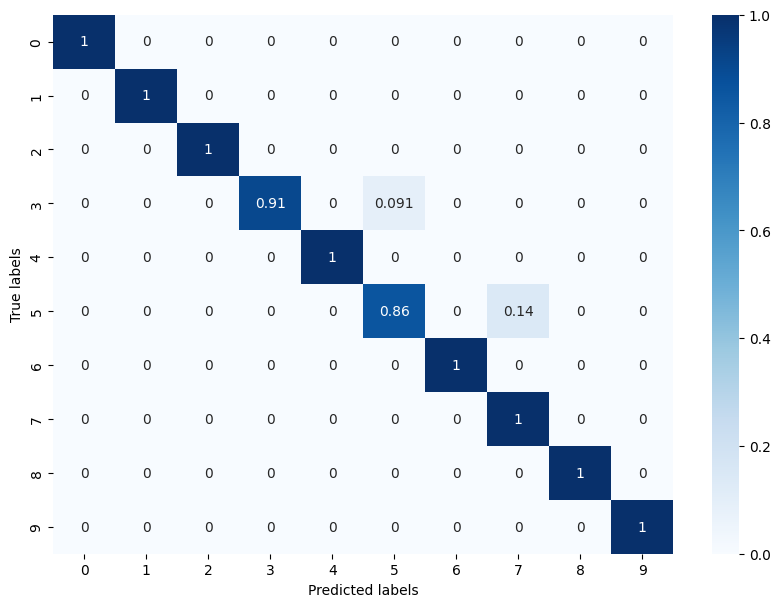

In [35]:
# setup the confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# get the predictions
predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)
plot_confusion_matrix(y_true, y_pred, id2label.values())

# Task 18: Save the Model and Metrics

In [39]:
# save the best model and metrics
trainer.save_model(output_dir)
trainer.save_metrics(output_dir, metrics=trainer.state.log_history[-1])
trainer.state.save_to_json(f'{output_dir}/trainer_state.json')

# Task 19: Push the model to huggingface

In [14]:
!huggingface-cli login
!huggingface-cli repo create mnist_vit -y

/Users/saip/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/saip/.cache/huggingface/token
Login successful
/Users/saip/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
git version 2.39.3 (Apple Git-145)
Looks like you do not have git-lfs installed, please install. You can install